# Proyecto Programación II (Regresión lineal múltiple):


---


- Jhon Fredy Aguirre García
- Leydy Vanesa Cortés Rosero




---



# Clases principales a utilizar:
- Regresión lineal múltiple.
- Regresión por componentes principales.
- Otras librerias propias de Python.

In [ ]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
class RegresionMultiple():
  def __init__(self,X,Y):
    self.fil,self.col=X.shape
    self.X=X
    self.Y=Y
    self.A=self.Matriz()
    self.Sol=self.SMC()

  def Matriz(self):
    A=np.ones((self.fil,self.col+1))
    A[:,1:]=self.X
    return A

  def SMC(self):
    Sol=np.linalg.inv(self.A.T@self.A)@self.A.T@self.Y
    return Sol

  def Evaluar(self,Datos):
    y_hat=self.Sol[0,0]
    for i in range(self.col):
      y_hat += self.Sol[i+1,0] * Datos[:,i]
    return y_hat

  def ErrorCuadratico(self):
    y_hat=self.Evaluar(self.X)
    Error=sum((self.Y[:,0]-y_hat)**2)
    return Error

  def MSE(self,y_hat,y):
    n=y.shape[0]
    Error=sum((y_hat-y[:,0])**2)/n
    return Error

  def R2(self,y_hat,y,P="N"):
    y_bar=np.mean(y)
    n=len(y)
    if str(P)=="N":
      num=sum((y_hat-y_bar)**2)
      dem=sum((y-y_bar)**2)
      R2=num/dem
    else:
      num=sum((y_hat-y[:,0])**2)
      dem=sum((y[:,0]-y_bar)**2)
      R2=1-(((n-1)/(n-P))*(num/dem))
    return R2

  def ValidacionCruzada(self,k,P="N"):
    indices = np.random.permutation(self.fil) #Se hace una permutación aleatoria de los (indices)individuos
    particiones = [indices[j::k] for j in range(k)]
    resultados = []
    for i in range(k):
      prueba = particiones[i]
      entrenamiento = np.concatenate([particiones[j] for j in range(k) if j != i])
      x_entrenamiento, y_entrenamiento = self.X[entrenamiento], self.Y[entrenamiento]
      x_prueba, y_prueba = self.X[prueba], self.Y[prueba]
      Modelo_i = RegresionMultiple(x_entrenamiento, y_entrenamiento)
      y_hat_prueba = Modelo_i.Evaluar(x_prueba)
      if str(P)=="N":
        R2 = Modelo_i.R2(y_hat_prueba, y_prueba)
      else:
        R2 = Modelo_i.R2(y_hat_prueba, y_prueba,P)
      resultados.append(R2)
    R2_promedio = sum(resultados)/len(resultados)
    return R2_promedio

  def Graficar(self,elev=20,azim=30):
    if self.col==2:
      x1=self.X[:,0]
      x2=self.X[:,1]
      y=self.Y
      # Crear una figura 3D
      fig = plt.figure()
      ax = fig.add_subplot(111, projection='3d')

      # Graficar la nube de puntos
      ax.view_init(elev=elev, azim=azim)
      ax.scatter(x1, x2, y)

      # Crear una malla de puntos para graficar el plano de regresión
      x1_grid, x2_grid = np.meshgrid(np.linspace(x1.min(), x1.max(), 10),
                                    np.linspace(x2.min(), x2.max(), 10))
      xy = np.array([x1_grid.flatten(), x2_grid.flatten()]).T
      xy = np.hstack((np.ones((xy.shape[0], 1)), xy))
      z_grid = xy @ self.Sol
      z_grid = z_grid.reshape(x1_grid.shape)

      # Graficar el plano de regresión
      ax.plot_surface(x1_grid, x2_grid, z_grid, alpha=0.5)

      # Etiquetar los ejes
      ax.set_xlabel('x1')
      ax.set_ylabel('x2')
      ax.set_zlabel('y')
      ax.set_title('Regresión lineal múltiple')

      # Mostrar la figura
      plt.show()

In [ ]:
class PCR(RegresionMultiple):
  num_comp=0
  def __init__(self,X,Y,margen):
    self.mediaX=X.mean(axis=0)
    self.DesvStanX=X.std(axis=0)
    self.mediaY=Y.mean(axis=0)
    self.DesvStanY=Y.std(axis=0)
    X_estandarizado=self.Estandarizar(X,self.mediaX,self.DesvStanX)
    Y_estandarizado=self.Estandarizar(Y)
    self.matrizPro=self.MatrizProyeccion(margen,X_estandarizado)
    Z=self.Proyectar(X_estandarizado)
    super().__init__(Z,Y_estandarizado)

  def Estandarizar(self,Datos,media="N",estandar="N"):
    if str(media)=="N" and str(estandar)=="N":
      media=Datos.mean(axis=0)
      estandar=Datos.std(axis=0)
    Datos_escalados = np.zeros_like(Datos)
    for k in range(Datos.shape[1]):
      if estandar[k]!=0:
        Datos_escalados[:,k] = (Datos[:,k]-media[k])/estandar[k]
      else:
        Datos_escalados[:,k] = Datos[:,k]
    return Datos_escalados

  def MatrizProyeccion(self,margen,X):
    U,S,VT=np.linalg.svd(X)
    V=VT.T
    S=S**2
    porcVarAcum =0
    k=1
    while porcVarAcum<margen:
      porcVarAcum = sum(S[:k])/sum(S)
      k +=1
    PCR.num_comp = k
    matrizPro= V[:,:PCR.num_comp]#La matriz de proyección
    return matrizPro

  def R2(self,y_hat,y):
    R2=super().R2(y_hat,y,PCR.num_comp)
    return R2

  def ValidacionCruzada(self, k,P="N"):
    return super().ValidacionCruzada(k,P)

  def Proyectar(self,Datos):
    Z=Datos@self.matrizPro
    return Z

  def Predecir(self,Datos):
    Datos_estandarizados=self.Estandarizar(Datos,self.mediaX,self.DesvStanX)
    Datos_proyectados=self.Proyectar(Datos_estandarizados)
    y_hat=super().Evaluar(Datos_proyectados)
    return y_hat

  def Desestandarizar(self,y_hat):
    y=y_hat*self.DesvStanY[0]+self.mediaY[0]
    return y

# Recopilación y preprocesamiento de los datos:

In [ ]:
# Leemos los datos que se encuentran en Drive:
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/MyDrive/Prog/Battery_RUL.csv")
data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107
...,...,...,...,...,...,...,...,...,...
15059,1108.0,770.44,179.523810,3.773,3.742,922.775,1412.38,6678.88,4
15060,1109.0,771.12,179.523810,3.773,3.744,915.512,1412.31,6670.38,3
15061,1110.0,769.12,179.357143,3.773,3.742,915.513,1412.31,6637.12,2
15062,1111.0,773.88,162.374667,3.763,3.839,539.375,1148.00,7660.62,1


In [ ]:
# Buscamos datos no reconocidos o errores en la base:
data.isna().sum()

Cycle_Index                  0
Discharge Time (s)           0
Decrement 3.6-3.4V (s)       0
Max. Voltage Dischar. (V)    0
Min. Voltage Charg. (V)      0
Time at 4.15V (s)            0
Time constant current (s)    0
Charging time (s)            0
RUL                          0
dtype: int64

In [ ]:
# Descripción de los datos:
data.describe()

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
count,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000
mean,556.155005,4581.273960,1239.784672,3.908176,3.577904,3768.336171,5461.266970,10066.496204,554.194172
std,322.378480,33144.012077,15039.589269,0.091003,0.123695,9129.552477,25155.845202,26415.354121,322.434514
min,1.000000,8.690000,-397645.908000,3.043000,3.022000,-113.584000,5.980000,5.980000,0.000000
25%,271.000000,1169.310000,319.600000,3.846000,3.488000,1828.884179,2564.310000,7841.922500,277.000000
50%,560.000000,1557.250000,439.239471,3.906000,3.574000,2930.203500,3824.260000,8320.415000,551.000000
75%,833.000000,1908.000000,600.000000,3.972000,3.663000,4088.326500,5012.350000,8763.282500,839.000000
max,1134.000000,958320.370000,406703.768000,4.363000,4.379000,245101.117000,880728.100000,880728.100000,1133.000000


<Axes: >

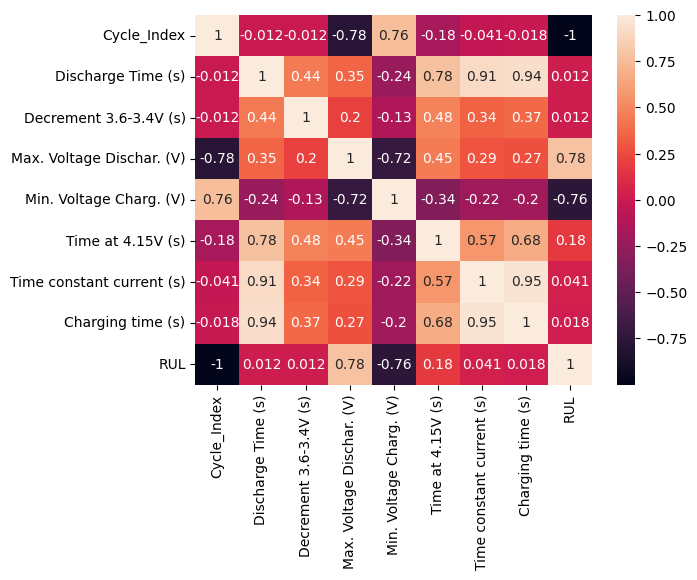

In [ ]:
# Mostramos la matriz de correlación para visualizar la dependencia que hay entre los datos:
corr = data.corr()
sns.heatmap(corr, annot=True)

Cycle_Index con respecto a RUL:

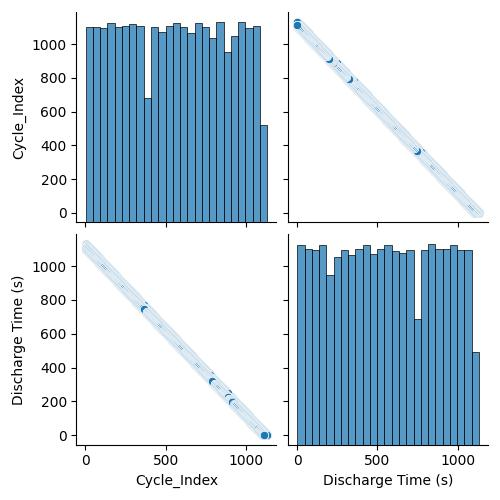

In [ ]:
# Etiquetamos cada una de las medidas con la bateria que le corresponde:
data['Battery ID']= 0
b=[]
j=1
for i in data['RUL']:
    b.append(j)
    if i == 0:
        j+=1
        continue
data['Battery ID'] = b
data.columns.tolist()
data

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL,Battery ID
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112,1
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111,1
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110,1
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109,1
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107,1
...,...,...,...,...,...,...,...,...,...,...
15059,1108.0,770.44,179.523810,3.773,3.742,922.775,1412.38,6678.88,4,14
15060,1109.0,771.12,179.523810,3.773,3.744,915.512,1412.31,6670.38,3,14
15061,1110.0,769.12,179.357143,3.773,3.742,915.513,1412.31,6637.12,2,14
15062,1111.0,773.88,162.374667,3.763,3.839,539.375,1148.00,7660.62,1,14


In [ ]:
# Usaremos  baterias para entrenamiento, las otras 5 serán usadas en las pruebas:
train_battery_ids = []
test_battery_ids = []
battery_ids = data['Battery ID'].unique()
for i in battery_ids:
    if i<=9:
        train_battery_ids.append(i)
    else:
        test_battery_ids.append(i)
train_data = data[data['Battery ID'].isin(train_battery_ids)]
test_data = data[data['Battery ID'].isin(test_battery_ids)]

In [ ]:
# Convertimos nuestros datos en matrices:
x_train = train_data.iloc[:,1:8].values # Prescindimos de la columna de datos Cycle_Index.
y_train = train_data.iloc[:,-2].values
y_train=y_train.reshape(len(y_train),1)
x_test = test_data.iloc[:,1:8].values
y_test = test_data.iloc[:,-2].values
y_test=y_test.reshape(len(y_test),1)

# Aplicación y evaluación de la regresión lineal múltiple:

In [ ]:
# Creamos el modelo de regresión:
ModReg = RegresionMultiple(x_train,y_train)

In [ ]:
# Solución de minimos cuadrados:
for i in range(len(ModReg.Sol)):
  print(f"Beta_{i} = {ModReg.Sol[i,0]}" )

Beta_0 = -8255.113876257205
Beta_1 = -0.008450762912490752
Beta_2 = -0.0006227804459565737
Beta_3 = 2822.305113930753
Beta_4 = -631.6674588665485
Beta_5 = 0.0029057947602037972
Beta_6 = 0.0021899046237161433
Beta_7 = 0.004548388749618867


In [ ]:
# Calculamos "y" estimado:
y_hat_test=ModReg.Evaluar(x_test)
# Métricas de ajuste:
print(f"Error cuadrático: {ModReg.ErrorCuadratico()}")
print(f"Error cuadrático medio (MSE): {ModReg.MSE(y_hat_test,y_test)}")
print(f"Coeficiente de determinación (R-cuadrado): {ModReg.R2(y_hat_test,y_test)[0]}")
print(f"Validación cruzada: {ModReg.ValidacionCruzada(7)[0]}")

Error cuadrático: 144912219.59032118
Error cuadrático medio (MSE): 37377.86377373016
Coeficiente de determinación (R-cuadrado): 0.8969645065489572
Validación cruzada: 0.8589846050042037


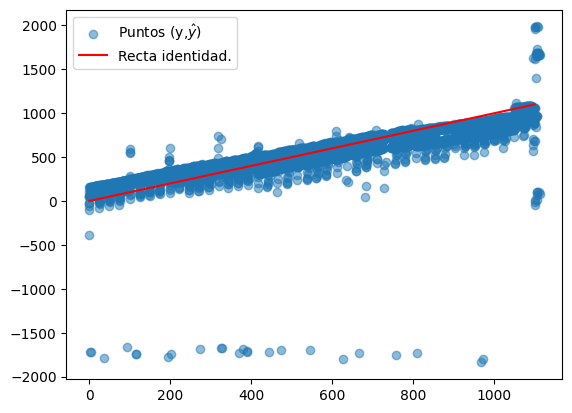

In [ ]:
# Gráfica en el plano de los puntos (y_original, y_estimado)
%matplotlib inline
ax = plt.axes()
ax.scatter(y_test, y_hat_test, alpha=.5,label="Puntos (y,$\hat{y}$)")
z=np.linspace(1,1100,1000000) # Recta identidad
ax.plot(z,z,"r",label="Recta identidad.")
plt.legend()

# Aplicación y evaluación de la regresión por componentes principales:

In [ ]:
# Creamos el modelo de regresión por componentes principales:
ModPCR = PCR(x_train,y_train,0.97)

In [ ]:
# Solución de minimos cuadrados:
for i in range(len(ModPCR.Sol)):
  print(f"Beta_{i} = {ModPCR.Sol[i,0]}" )

Beta_0 = 0.005047383601153591
Beta_1 = 0.07250243974979032
Beta_2 = 0.39322702892670275
Beta_3 = 0.07448279983502598
Beta_4 = 0.08299511366462949
Beta_5 = 0.18271944623303468
Beta_6 = 0.5638891736636773


In [ ]:
# Calculamos "y" estimado:
y_hat_test=ModPCR.Desestandarizar(ModPCR.Predecir(x_test))
# Métricas de ajuste:
print(f"Error cuadrático: {ModPCR.ErrorCuadratico()}")
print(f"Error cuadrático medio (MSE): {ModPCR.MSE(y_hat_test,y_test)}")
print(f"Coeficiente de determinación ajustado (R-cuadrado ajustado): {ModPCR.R2(y_hat_test,y_test)}")
print(f"Validación cruzada: {ModPCR.ValidacionCruzada(7)[0]}")

Error cuadrático: 1399.0044926044843
Error cuadrático medio (MSE): 42793.839443493336
Coeficiente de determinación ajustado (R-cuadrado ajustado): 0.5869455538996088
Validación cruzada: 0.6634630496762635


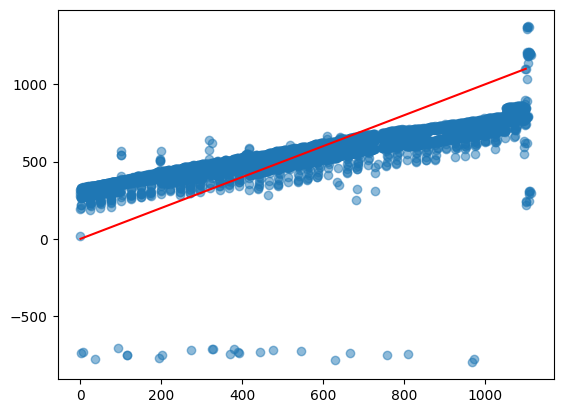

In [ ]:
# Gráfica en el plano de los puntos (y_original, y_estimado)
%matplotlib inline
ax = plt.axes()
ax.scatter(y_test, y_hat_test, alpha=.5)
z=np.linspace(1,1100,1000000) # Recta identidad
ax.plot(z,z,"r")

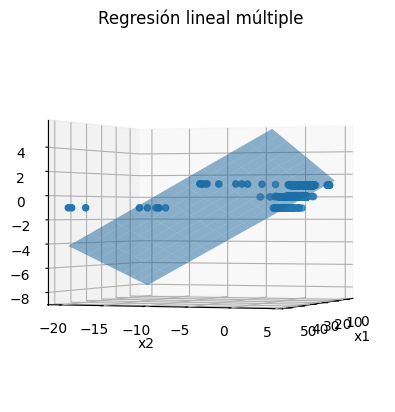

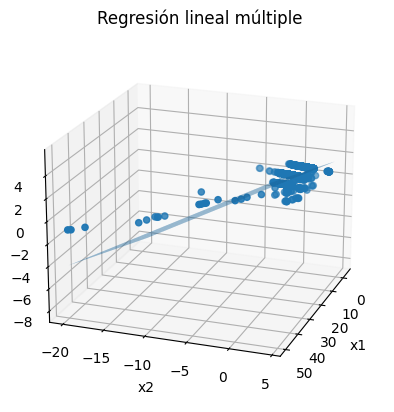

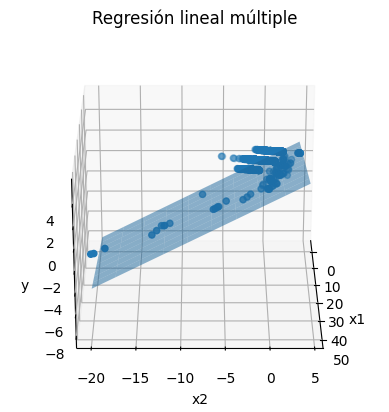

In [ ]:
# Podemos graficar cuando el margen es del 55%
ModPCR = PCR(x_train,y_train,0.55)
y_hat_test=ModPCR.Desestandarizar(ModPCR.Predecir(x_test))
ModPCR.Graficar(0,20)
ModPCR.Graficar(20,20)
ModPCR.Graficar(25,0)

In [ ]:
print(f"Error cuadrático: {ModPCR.ErrorCuadratico()}")
print(f"Error cuadrático medio (MSE): {ModPCR.MSE(y_hat_test,y_test)}")
print(f"Coeficiente de determinación ajustado (R-cuadrado ajustado): {ModPCR.R2(y_hat_test,y_test)}")
print(f"Validación cruzada: {ModPCR.ValidacionCruzada(7)[0]}")
# Solución de minimos cuadrados:
for i in range(len(ModPCR.Sol)):
  print(f"Beta_{i} = {ModPCR.Sol[i,0]}" )

Error cuadrático: 1686.365556294486
Error cuadrático medio (MSE): 46346.02042620815
Coeficiente de determinación ajustado (R-cuadrado ajustado): 0.5529934239751098
Validación cruzada: 0.5978992344157931
Beta_0 = 0.005047383601153924
Beta_1 = 0.07250243974979016
Beta_2 = 0.3932270289267028


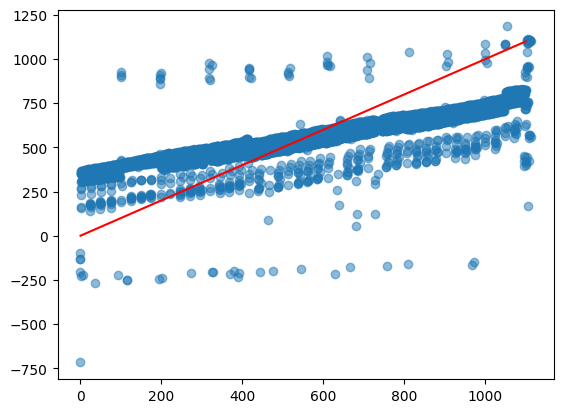

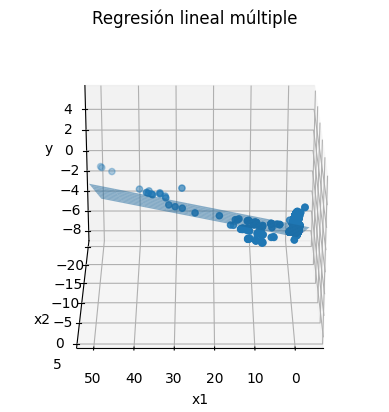

In [ ]:
# Gráfica en el plano de los puntos (y_original, y_estimado)
%matplotlib inline
ax = plt.axes()
ax.scatter(y_test, y_hat_test, alpha=.5)
z=np.linspace(1,1100,1000000) # Recta identidad
ax.plot(z,z,"r")

ModPCR.Graficar(25,90)

<function matplotlib.pyplot.show(close=None, block=None)>

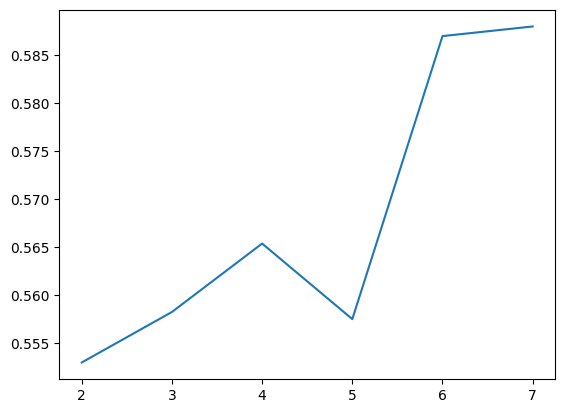

In [ ]:
# Diferentes valores para PCR:
Varianza=np.linspace(55,100,30)/100
R2=[]
Comp=[]
for i in (Varianza):
  Mod=PCR(x_train,y_train,i)
  y_hat_test=Mod.Desestandarizar(Mod.Predecir(x_test))
  R2.append(Mod.R2(y_hat_test,y_test))
  Comp.append(Mod.X.shape[1])
plt.plot(Comp,R2)
plt.show